In [19]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import torch
from torch import nn
from tqdm.auto import tqdm #progress bar
from torchvision import transforms
from torchvision.datasets import MNIST 
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [20]:
def get_generator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )
def get_discriminator_block(input_dim, output_dim):
    return nn.Sequential(
        nn.Linear(input_dim,output_dim),
        nn.LeakyReLU(0.2)
    )

In [21]:
class Generator(nn.Module):
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim*8,im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        return self.gen(noise)

class Discriminator(nn.Module):
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim,1)
        )

    def forward(self, image):
        return self.disc(image)

In [22]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn((n_samples,z_dim),device=device)

In [27]:
criterion = nn.BCEWithLogitsLoss()
z_dim = 64
batch_size = 128
lr = 0.00001
device = 'cpu'

dataloader = DataLoader(
    MNIST('.', download=False, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [24]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    noise=get_noise(num_images,z_dim,device=device)
    fake=gen(noise).detach()
    pred_fake=disc(fake)
    ground_truth_fake=torch.zeros_like(pred_fake)
    loss1=criterion(pred_fake,ground_truth_fake)
    pred_real=disc(real)
    ground_truth_real=torch.ones_like(pred_real)
    loss2=criterion(pred_real,ground_truth_real)
    disc_loss=((loss1+loss2)/2)
    return disc_loss

def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    noise=get_noise(num_images,z_dim,device=device)
    fake=gen(noise)
    pred=disc(fake)
    real_like=torch.ones_like(pred)
    gen_loss=criterion(pred,real_like)
    return gen_loss

Step 468: Generator loss: 3.140534014783353,discriminator loss: 0.09130628168200844


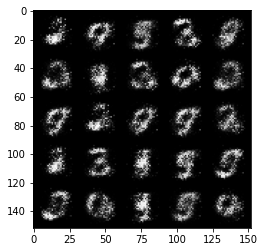

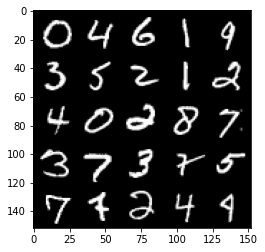

Step 936: Generator loss: 3.410146096323295,discriminator loss: 0.07086099872890957


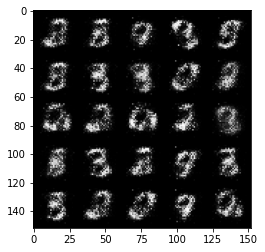

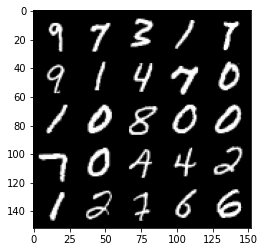

In [34]:
n_epochs = 2
cur_step = 0
display_step = 468
mean_generator_loss = 0
mean_discriminator_loss = 0

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

for epoch in range(n_epochs):
  
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        real = real.view(cur_batch_size, -1).to(device)

        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        
        gen_opt.zero_grad()
        gen_loss=get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()

        mean_discriminator_loss += disc_loss.item() / display_step

        mean_generator_loss += gen_loss.item() / display_step
        
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss},discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1